# Negative correlation learning
## Načtení dat

In [1]:
import pandas as pd
import sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

vowel_train = pd.read_csv('data/vowel/train.txt')
vowel_test = pd.read_csv('data/vowel/test.txt')

diab_list = []
for i in range(2, 70):
    path = "data/diabetes/data-{:02d}".format(i)
    to_append = pd.read_csv(path, sep="\t", names=['date', 'time', 'code', 'y'])
    diab_list.append(to_append)
diabetes_data = pd.concat(diab_list)

glass_data = pd.read_csv('data/glass/glass.data', \
                         names=['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'y'])
glass_data = glass_data.drop('Id', axis = 1)

## Data preprocessing
### Diabetes

In [2]:
diabetes_data = diabetes_data[diabetes_data['y'].notnull()]    
diabetes_data = diabetes_data[~diabetes_data['y'].isin(['0Hi', '0Lo', '3A'])]
diabetes_data['y'] = diabetes_data['y'].apply(lambda x: str(x).strip('\''))
diabetes_data['y'] = diabetes_data['y'].astype('float')

In [3]:
diabetes_data['y'] = pd.cut(diabetes_data['y'], bins = 5, labels=False)

In [4]:
diabetes_data['date'] = diabetes_data['date'].replace('06-31-1991', '06-30-1991')
diabetes_data['time'] = diabetes_data['time'].replace('006', '06:00')
diabetes_data['time'] = diabetes_data['time'].replace('016', '16:00')
diabetes_data['time'] = diabetes_data['time'].replace('004', '04:00')
diabetes_data['time'] = diabetes_data['time'].replace('018', '18:00')
diabetes_data['time'] = diabetes_data['time'].replace('020', '20:00')
diabetes_data['time'] = diabetes_data['time'].replace('56:35', '6:35')
diabetes_data['time'] = diabetes_data['time'].replace('188:00', '18:00')
diabetes_data['date'] = pd.to_datetime(diabetes_data['date'], format='%m-%d-%Y')
diabetes_data['time'] = pd.to_datetime(diabetes_data['time'], format='%H:%M')
months = months = diabetes_data['date'].dt.year * 12 + diabetes_data['date'].dt.month
days = diabetes_data['date'].dt.day + months * 31
diabetes_data['date'] = days
hours = diabetes_data['time'].dt.minute * 60 + diabetes_data['time'].dt.hour
diabetes_data['time'] = hours

In [5]:
diabetes_data = diabetes_data[diabetes_data['date'].notnull()]

In [6]:
from sklearn.model_selection import train_test_split

tr_c = vowel_train.count()[0]
te_c = vowel_test.count()[0]
test_s = te_c/(tr_c + te_c)
diabetes_train, diabetes_test = train_test_split(diabetes_data, test_size = test_s)

In [7]:
vowel_train.drop('row.names', axis=1, inplace=True)
vowel_test.drop('row.names', axis=1, inplace=True)

### Glass

In [8]:
glass_train, glass_test = train_test_split(glass_data, test_size = test_s)

## Algoritmus
Algoritmus je rozdělen do dvou tříd. Jedna z nich zachycuje samotný algoritmus AdaBoost (`AdaBoostNC`). Druhá (`AdaBoostIndividual`) je wrapperem rozhodovacího stromu, který si pamatuje skóre negativní korelace pro jednotlivé vzorky z učících dat.

In [9]:
import random
import math

class AdaBoostIndividual():
    def __init__(self, data, base_estimator = DecisionTreeClassifier(), allow_nc = True,\
                 nc_param = 0.5, random_init = True):
        data_len = data.count()[0]
        self.classifier = base_estimator
        self.detected_right = [0] * data_len
        self.nc_ranks = [1] * data_len
        if random_init:
            for i in range(len(self.nc_ranks)):
                self.nc_ranks[i] = random.randint(0, 10) / 10
        self.weight = 1
        if not allow_nc: nc_param = 0
        self.nc_param = nc_param
        
    def fit(self, X, y, data_weights):
        weights = list(data_weights)
        for i in range(len(weights)):
            dr = 0 if self.detected_right[i] else 1
            weights[i] *= self.get_nc_penalty(i) * math.exp(-dr * self.weight)
        selected_weights = []
        weight_sum = 0
        for index, row in X.iterrows():
            weight_sum += weights[index]
            selected_weights.append(weights[index])
        for i in range(len(selected_weights)):
            selected_weights[i] /= weight_sum
        return self.classifier.fit(X, y, sample_weight = selected_weights)
    
    def get_nc_penalty(self, i):
        return (1 - self.nc_param) + self.nc_param * self.nc_ranks[i]
    
    def predict(self, X):
        return self.classifier.predict(X)
        
    def set_detected_right(self, detected_right):
        self.detected_right = detected_right

    def compute_weight(self, data_weights):
        detected_ok = - 1e-100
        detected_ko = - 1e-100
        for i in range(len(self.detected_right)):
            val = self.detected_right[i]
            to_add = data_weights[i] * self.get_nc_penalty(i)
            if val:
                detected_ok += to_add
            else:
                detected_ko += to_add
        ok_to_ko = detected_ok/detected_ko
        return (math.log(ok_to_ko))/2

    def update_nc_ranks(self, another):
        for i in range(len(self.detected_right)):
            dr = self.detected_right[i]
            rank = 0
            for individual in another:
                rank -= 0 if individual.detected_right[i] else 1
            rank *= 1 if dr else 0
            rank /= len(another) + 1
            self.nc_ranks[i] = 1 -rank
            
    def turbokoeficient(self, i):
        dr = 0.5 if self.detected_right[i] else 1
        return self.weight + dr
            
    def get_detected_right(self):
        return self.detected_right

In [10]:
import math
from sklearn.model_selection import train_test_split

class AdaBoostNC():
    def __init__(self, base_estimator = DecisionTreeClassifier, allow_nc = True, \
                 nc_param = 0.5, number_of_individuals = 10, number_of_training_epochs = 20, \
                 random_init = True):
        self.base_estimator = base_estimator
        self.num_of_training_epochs = number_of_training_epochs
        self.num_of_individuals = number_of_individuals
        self.allow_nc = allow_nc
        self.nc_param = nc_param
        self.random_init = random_init
        
    def set_nc_param(self, nc_param):
        self.nc_param = nc_param
    
    def fit(self, data_x, data_y):
        data = data_x.copy()
        data['y'] = data_y
        data = data.reset_index()
        
        data_len = data.count()[0]
        data_weights = [1/data_len] * data_len
        
        self.individuals = self.generate_individuals(data)
            
        for epoch in range(self.num_of_training_epochs):
            train_x, test_x = train_test_split(data, test_size = 0.3)

            train_y = train_x['y']
            train_x = train_x.drop(['y', 'index'], axis=1)
            test_x = data.copy()
            test_y = test_x['y']
            test_x.drop(['y', 'index'], axis=1, inplace=True)
        
            for individual in self.individuals:
                individual.fit(train_x, train_y, data_weights)
                prediction = individual.predict(test_x)
                detected_right = [False] * len(prediction)
                for row in range(len(test_y)):
                    detected_right[row] = prediction[row] == test_y[row]
                individual.set_detected_right(detected_right)
                individual.compute_weight(data_weights)
            for individual in self.individuals:
                another = list(self.individuals)
                another.remove(individual)
                individual.update_nc_ranks(another)
            data_weights = self.update_data_weights(data_weights)
    
    def update_data_weights(self, data_weights):
        ndw = list(data_weights)
        for i in range(len(data_weights)):
            ndw[i] *= math.exp(-self.turbokoeficient(i))
        return ndw 
    
    def generate_individuals(self, data):
        individuals = []
        for i in range(self.num_of_individuals):
            individual = AdaBoostIndividual(data,\
                                            #base_estimator = self.base_estimator(),\
                                            base_estimator = DecisionTreeClassifier(),
                                            allow_nc = self.allow_nc,
                                            nc_param = self.nc_param,
                                            random_init = self.random_init)
            individuals.append(individual)
        return individuals
    
    def turbokoeficient(self, i):
        coef = 0
        for individual in self.individuals:
            coef += individual.turbokoeficient(i)
        return coef / len(self.individuals)

    def predict(self, X):
        predictions = []
        for individual in self.individuals:
            prediction = individual.predict(X)
            predictions.append(pd.DataFrame(prediction))
        df = pd.concat(predictions)
        result = df.groupby(df.index).median()
        result = result.astype('int')
        return result

## Testování
### Definice testovací funkce

In [11]:
from sklearn.metrics import confusion_matrix

def test(clf, train_x, train_y, test_x, test_y):
    clf.fit(train_x, train_y)
    prediction = clf.predict(test_x)
    cm = confusion_matrix(test_y, prediction)
    e_true = 0
    for i in range(len(cm)):
        e_true += cm[i][i]
    e_all = test_y.count()
    accuracy = e_true / e_all
    print("Accuracy: {:f} %".format(accuracy))
    return accuracy

def test_one_dataset(classifier, dtrain, dtest):
    train_x = dtrain.drop('y', axis=1)
    train_y = dtrain['y']
    test_x = dtest.drop('y', axis=1)
    test_y = dtest['y']
    return test(classifier, train_x, train_y, test_x, test_y)

def test_all_datasets(classifier, vowel_tr, vowel_te, dia_tr, dia_te, glass_tr, glass_te, set_nc_param=False):
    print('Vowel')
    if set_nc_param: classifier.set_nc_param(0.7)
    v = test_one_dataset(classifier, vowel_tr, vowel_te)
    print('Diabetes')
    if set_nc_param: classifier.set_nc_param(0.7)
    d = test_one_dataset(classifier, dia_tr, dia_te)
    print('Glass')
    if set_nc_param: classifier.set_nc_param(0.1)
    g = test_one_dataset(classifier, glass_tr, glass_te)
    return v, d, g

### Random forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

test_all_datasets(RandomForestClassifier(), \
                  vowel_train, vowel_test, \
                  diabetes_train, diabetes_test, \
                  glass_train, glass_test)

Vowel
Accuracy: 0.489177 %
Diabetes
Accuracy: 0.741019 %
Glass
Accuracy: 0.750000 %


(0.48917748917748916, 0.74101876675603218, 0.75)

### AdaBoost (z knihovny sklearn) + rozhodovací stromy

In [13]:
ada = AdaBoostClassifier(base_estimator = DecisionTreeClassifier())
test_all_datasets(ada, \
                  vowel_train, vowel_test, \
                  diabetes_train, diabetes_test, \
                  glass_train, glass_test)

Vowel
Accuracy: 0.430736 %
Diabetes
Accuracy: 0.739563 %
Glass
Accuracy: 0.650000 %


(0.43073593073593075, 0.73956338567598623, 0.65000000000000002)

### Mnou implementovaný (upravený) AdaBoost bez NC
Více stromů v každé iteraci:

In [14]:
anc = AdaBoostNC(allow_nc = False)
test_all_datasets(anc, \
                  vowel_train, vowel_test, \
                  diabetes_train, diabetes_test, \
                  glass_train, glass_test)

Vowel
Accuracy: 0.391775 %
Diabetes
Accuracy: 0.725929 %
Glass
Accuracy: 0.650000 %


(0.39177489177489178, 0.72592876292608199, 0.65000000000000002)

Jeden strom v každé iteraci:

In [15]:
anc = AdaBoostNC(allow_nc = False, number_of_individuals = 1)
test_all_datasets(anc, \
                  vowel_train, vowel_test, \
                  diabetes_train, diabetes_test, \
                  glass_train, glass_test)

Vowel
Accuracy: 0.404762 %
Diabetes
Accuracy: 0.720260 %
Glass
Accuracy: 0.630000 %


(0.40476190476190477, 0.72026043661432404, 0.63)

### Mnou implementované algoritmy -- AdaBoost.NC
Více stromů v každé iteraci:

In [16]:
anc = AdaBoostNC(random_init = False, nc_param=0.7)
test_all_datasets(anc, \
                  vowel_train, vowel_test, \
                  diabetes_train, diabetes_test, \
                  glass_train, glass_test, \
                  set_nc_param=True)

Vowel
Accuracy: 0.467532 %
Diabetes
Accuracy: 0.728610 %
Glass
Accuracy: 0.590000 %


(0.46753246753246752, 0.72860972807353508, 0.58999999999999997)

Jeden strom v každé iteraci:

In [17]:
anc = AdaBoostNC(number_of_individuals = 1, random_init = False, nc_param=0.7)
test_all_datasets(anc, \
                  vowel_train, vowel_test, \
                  diabetes_train, diabetes_test, \
                  glass_train, glass_test, \
                  set_nc_param=True)

Vowel
Accuracy: 0.406926 %
Diabetes
Accuracy: 0.727078 %
Glass
Accuracy: 0.730000 %


(0.40692640692640691, 0.72707774798927616, 0.72999999999999998)

### Mnou implementované algoritmy -- AdaBoost.NC s náhodnou inicializací
Více stromů v každé iteraci:

In [18]:
anc = AdaBoostNC(nc_param=0.7)
test_all_datasets(anc, \
                  vowel_train, vowel_test, \
                  diabetes_train, diabetes_test, \
                  glass_train, glass_test, \
                  set_nc_param=True)

Vowel
Accuracy: 0.393939 %
Diabetes
Accuracy: 0.727767 %
Glass
Accuracy: 0.670000 %


(0.39393939393939392, 0.7277671390271927, 0.67000000000000004)

Jeden strom v každé instanci:

In [19]:
anc = AdaBoostNC(number_of_individuals = 1, nc_param=0.7)
test_all_datasets(anc, \
                  vowel_train, vowel_test, \
                  diabetes_train, diabetes_test, \
                  glass_train, glass_test, \
                  set_nc_param=True)

Vowel
Accuracy: 0.398268 %
Diabetes
Accuracy: 0.727844 %
Glass
Accuracy: 0.620000 %


(0.39826839826839827, 0.72784373803140556, 0.62)

### Různé váhy negativní korelace (parametr $\lambda$ v reportu)

In [20]:
vowel_train_train, vowel_valid = train_test_split(vowel_train, test_size = 0.5)
dia_train_train, dia_valid = train_test_split(vowel_train, test_size = 0.5)
glass_train_train, glass_valid = train_test_split(vowel_train, test_size = 0.5)

vowels = []
diabetes = []
glass = []
lambdas = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
for lmb in lambdas:
    print('λ =', lmb)
    anc = AdaBoostNC(nc_param = lmb)
    a_v, a_d, a_g = test_all_datasets(anc, \
                                      vowel_train_train, vowel_valid,\
                                      dia_train_train, dia_valid, \
                                      glass_train_train, glass_valid)
    vowels.append(a_v)
    diabetes.append(a_d)
    glass.append(a_g)
    print()

λ = 0
Vowel
Accuracy: 0.674242 %
Diabetes
Accuracy: 0.670455 %
Glass
Accuracy: 0.685606 %

λ = 0.1
Vowel
Accuracy: 0.685606 %
Diabetes
Accuracy: 0.666667 %
Glass
Accuracy: 0.651515 %

λ = 0.3
Vowel
Accuracy: 0.685606 %
Diabetes
Accuracy: 0.647727 %
Glass
Accuracy: 0.681818 %

λ = 0.5
Vowel
Accuracy: 0.723485 %
Diabetes
Accuracy: 0.700758 %
Glass
Accuracy: 0.602273 %

λ = 0.7
Vowel
Accuracy: 0.628788 %
Diabetes
Accuracy: 0.662879 %
Glass
Accuracy: 0.678030 %

λ = 0.9
Vowel
Accuracy: 0.655303 %
Diabetes
Accuracy: 0.689394 %
Glass
Accuracy: 0.640152 %



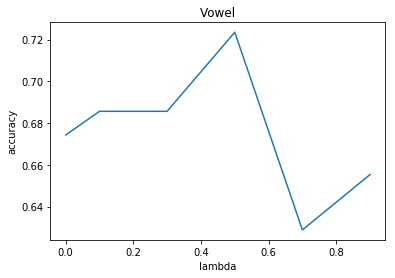

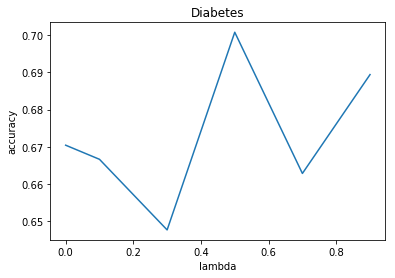

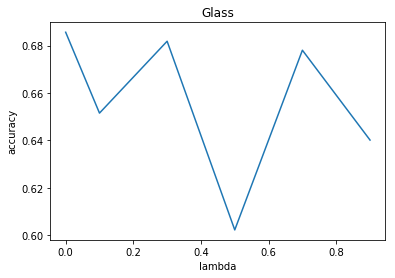

In [21]:
import matplotlib.pyplot as plt

def draw_plot_lambda(data, file_name, title):
    plt.plot(lambdas, data)
    plt.ylabel('accuracy')
    plt.xlabel('lambda')
    plt.title(title)
    #plt.savefig(file_name)
    plt.show()
    
draw_plot_lambda(vowels, 'lambda-vowels.pdf', 'Vowel')
draw_plot_lambda(diabetes, 'lambda-diabetes.pdf', 'Diabetes')
draw_plot_lambda(glass, 'lambda-glass.pdf', 'Glass')

### Mnou implementované algoritmy -- Vše výše zmíněné + SVM místo rozhodovacích stromů

In [22]:
from sklearn.svm import SVC

anc = AdaBoostNC(base_estimator = SVC)
test_all_datasets(anc, \
                  vowel_train, vowel_test, \
                  diabetes_train, diabetes_test, \
                  glass_train, glass_test)

Vowel
Accuracy: 0.428571 %
Diabetes
Accuracy: 0.730065 %
Glass
Accuracy: 0.690000 %


(0.42857142857142855, 0.73006510915358103, 0.68999999999999995)

s jedním SVM v iteraci:

In [23]:
from sklearn.svm import SVC

anc = AdaBoostNC(base_estimator = SVC, number_of_individuals = 1)
test_all_datasets(anc, \
                  vowel_train, vowel_test, \
                  diabetes_train, diabetes_test, \
                  glass_train, glass_test)

Vowel
Accuracy: 0.402597 %
Diabetes
Accuracy: 0.724244 %
Glass
Accuracy: 0.710000 %


(0.40259740259740262, 0.72424358483339712, 0.70999999999999996)